In [1]:
import numpy as np
import cv2
import os
import pickle
import random
import shutil
import sys
import time
import zipfile
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

In [2]:
import pahaw_loader
import nn

In [3]:
import random
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

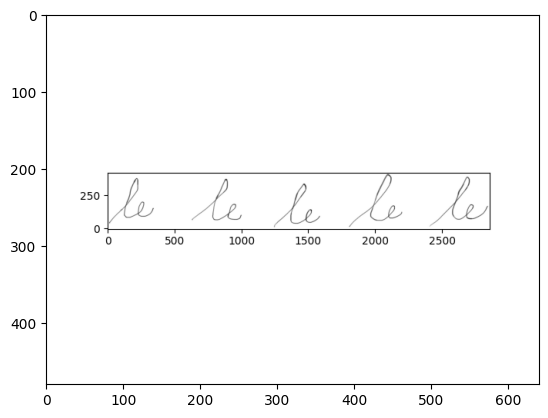

In [4]:
img0 = cv2.imread("tareas_generadas/sujeto1/tarea3.png", 0)
plt.imshow(img0 ,cmap="gray",vmin=0,vmax=255)
plt.show()

In [4]:
subjects_pd_status_years, subjects_tasks = pahaw_loader.load()

: 

In [5]:
#task1 = subjects_tasks[57][2]
#task1_ls = task1.letters_sets_list
#st_list = task1_ls[0].strokes_list

In [6]:
def bresenham_line(x1, y1, x2, y2, matrix, thickness=1, darkening_factor=0.5):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = 1 if x2 > x1 else -1
    sy = 1 if y2 > y1 else -1
    half = thickness // 2

    def darken_pixel_block(x, y):
        y_start = max(0, y - half)
        y_end = min(matrix.shape[0], y + half + 1)
        x_start = max(0, x - half)
        x_end = min(matrix.shape[1], x + half + 1)
    
        for yy in range(y_start, y_end):
            for xx in range(x_start, x_end):
                if (xx - x)**2 + (yy - y)**2 <= half**2:
                    matrix[yy, xx] *= darkening_factor

    if dx > dy:
        err = dx / 2.0
        while x != x2:
            darken_pixel_block(x, y)
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            darken_pixel_block(x, y)
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy

    darken_pixel_block(x2, y2)
    return matrix

In [7]:
def applyThickness(x_coords, y_coords, pressures, id):
    min_p, max_p = min(pressures), max(pressures)
    print(min_p)
    print(max_p)

    if max_p - min_p == 0:
        normalized_pressures = [0.5] * len(pressures)
    else:
        normalized_pressures = [(p - min_p) / (max_p - min_p) for p in pressures]

    min_line_width = 0
    max_line_width = 15
    lwidths_segments_full = [
        min_line_width + (max_line_width - min_line_width) * np_val
        for np_val in normalized_pressures
    ]
    lwidths_segments = lwidths_segments_full[:-1]

    #min_point_size = 10
    #max_point_size = 60
    #lwidths_points = [
    #    min_point_size + (max_point_size - min_point_size) * np_val
    #    for np_val in normalized_pressures
    #]
    visual_area_scaling_factor = 1

    lwidths_points = [
        (segment_width_at_point * visual_area_scaling_factor)**2
        for segment_width_at_point in lwidths_segments_full
    ]

    # Preparar segmentos de línea
    points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Crear el gráfico
    lc = LineCollection(segments, linewidths=lwidths_segments, color='black')
    fig, a = plt.subplots(2, figsize=(24, 24))

    padding=10
    # Trazo con grosor en a[0]
    a[0].add_collection(lc)
    a[0].scatter(x_coords, y_coords, color="black", s=lwidths_points, edgecolor="none")  # puntos
    a[0].set_xlim(min(x_coords) - padding, max(x_coords) + padding)
    a[0].set_ylim(min(y_coords) - padding, max(y_coords) + padding)
    a[0].set_aspect('equal')
    a[0].set_title("Trazo con grosor + puntos")

    # Solo scatter en a[1]
    a[1].scatter(x_coords, y_coords, color="black", edgecolor="none")
    a[1].set_xlim(min(x_coords) - padding, max(x_coords) + padding)
    a[1].set_ylim(min(y_coords) - padding, max(y_coords) + padding)
    a[1].set_aspect('equal')
    a[1].set_title("Solo puntos")

    plt.tight_layout()
    plt.savefig(f"{id}_resultado.png")
    plt.close()

In [37]:
for task_number in range(1, 9):    
    subject_id = list(subjects_tasks.keys())[3]
    cont = 0
    margin = 30
    all_x = []
    all_y = []

    for letters_set in subjects_tasks[subject_id][task_number].letters_sets_list:
            for stroke in letters_set.strokes_list:
                stroke_x_list = stroke.get_x_coordinates_list()
                stroke_y_list = stroke.get_y_coordinates_list()
                all_x.extend(stroke_x_list)
                all_y.extend(stroke_y_list)
    canvas = np.ones((max(all_y) - min(all_y) + margin, max(all_x) - min(all_x) + margin),dtype=np.float64)*255.0
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    for letters_set in subjects_tasks[subject_id][task_number].letters_sets_list:
            # Primero se genera el plot de los trazos originales en base a la predicción
            # de la letra. De esta manera no quedan huecos entre los nuevos trazos.
            for stroke in letters_set.strokes_list:
                pressures = subjects_pressures[subject_id][task_number][cont]
                altitudes = subjects_altitude[subject_id][task_number][cont]
                min_p, max_p = min(pressures), max(pressures)
                if max_p - min_p == 0:
                    normalized_pressures = [0.5] * len(pressures)
                else:
                    normalized_pressures = [(p - min_p) / (max_p - min_p) for p in pressures]

                min_a, max_a = min(altitudes), max(altitudes)
                if max_a - min_a == 0:
                    normalized_altitudes = [2] * len(altitudes)
                else:
                    normalized_altitudes = [(a - min_a) / (max_a - min_a) for a in altitudes]


                stroke_x_list = stroke.get_x_coordinates_list()
                stroke_y_list = stroke.get_y_coordinates_list()

                normalized_x = [x - min_x for x in stroke_x_list]
                normalized_y = [y - min_y for y in stroke_y_list]

                for i in range(len(stroke_x_list) - 1):
                    if i < len(normalized_pressures): darkening_factor = 1.0 - 0.2 * normalized_pressures[i]
                    if i < len(normalized_altitudes): thickness_factor = 10 - 4 * normalized_altitudes[i]
                    bresenham_line(normalized_x[i], normalized_y[i], normalized_x[i+1], normalized_y[i+1], canvas, thickness=int(thickness_factor), darkening_factor=darkening_factor)
                    i+=1

                cont+=1

    #            print(f"Longitud presiones {cont}: {len(subjects_pressures[subject_id][task_number][cont])} VS {len(stroke_x_list)}")
    #            applyThickness(stroke_x_list, stroke_y_list, subjects_pressures[subject_id][task_number][cont], cont)
    #            cont+=1

    plt.imshow(canvas ,cmap="gray",vmin=0,vmax=255)
    plt.gca().invert_yaxis()
    plt.savefig(f"tarea{task_number}.png")
    plt.close()



553


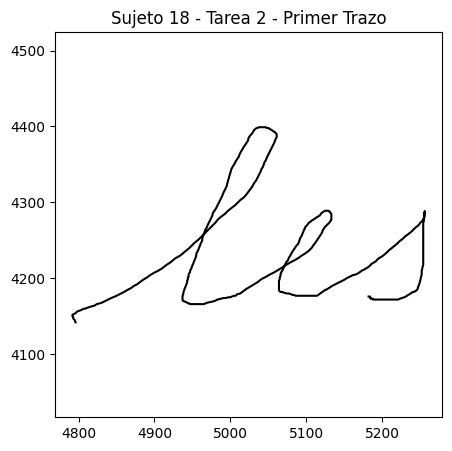

In [77]:
subject_id = list(subjects_tasks.keys())[15]
task = subjects_tasks[subject_id][4]

letters_set = task.letters_sets_list[0]
stroke = letters_set.strokes_list[0]

pressures = subjects_pressures[subject_id][3][0]


x = stroke.get_x_coordinates_list()
y = stroke.get_y_coordinates_list()


print(len(x))

plt.figure(figsize=(5,5))
plt.plot(x, y, color="black")
plt.axis('equal')
plt.title(f"Sujeto {subject_id} - Tarea 2 - Primer Trazo")
plt.show()

In [ ]:
#subject_id = list(subjects_tasks.keys())[2]
#task_number = 4
#cont = 0
#for letters_set in subjects_tasks[subject_id][task_number].letters_sets_list:
#        # Primero se genera el plot de los trazos originales en base a la predicción
#        # de la letra. De esta manera no quedan huecos entre los nuevos trazos.
#        for stroke in letters_set.strokes_list:
#            stroke_x_list = stroke.get_x_coordinates_list()
#            stroke_y_list = stroke.get_y_coordinates_list()
#            print(f"Longitud presiones {cont}: {len(subjects_pressures[subject_id][task_number][cont])} VS {len(stroke_x_list)}")
#            applyThickness(stroke_x_list, stroke_y_list, subjects_pressures[subject_id][task_number][cont], cont)
#            cont+=1
#

In [ ]:
#Imagen gris con buena presion y altitud pero sin intersecciones

#def bresenham_line(x1, y1, x2, y2, matrix, thickness=1, intensity=255):
#    dx = abs(x2 - x1)
#    dy = abs(y2 - y1)
#    x, y = x1, y1
#    sx = 1 if x2 > x1 else -1
#    sy = 1 if y2 > y1 else -1
#    half = thickness // 2
#
#    def draw_pixel_block(x, y):
#        y_start = max(0, y - half)
#        y_end = min(matrix.shape[0], y + half + 1)
#        x_start = max(0, x - half)
#        x_end = min(matrix.shape[1], x + half + 1)
#        matrix[y_start:y_end, x_start:x_end] = np.minimum(matrix[y_start:y_end, x_start:x_end], intensity)
#
#    if dx > dy:
#        err = dx / 2.0
#        while x != x2:
#            draw_pixel_block(x, y)
#            err -= dy
#            if err < 0:
#                y += sy
#                err += dx
#            x += sx
#    else:
#        err = dy / 2.0
#        while y != y2:
#            draw_pixel_block(x, y)
#            err -= dx
#            if err < 0:
#                x += sx
#                err += dy
#            y += sy
#
#    draw_pixel_block(x2, y2)
#    return matrix
#
#subject_id = list(subjects_tasks.keys())[2]
#task_number = 4
#cont = 0
#for letters_set in subjects_tasks[subject_id][task_number].letters_sets_list:
#        # Primero se genera el plot de los trazos originales en base a la predicción
#        # de la letra. De esta manera no quedan huecos entre los nuevos trazos.
#        for stroke in letters_set.strokes_list:
#            pressures = subjects_pressures[subject_id][task_number][cont]
#            altitudes = subjects_altitude[subject_id][task_number][cont]
#            min_p, max_p = min(pressures), max(pressures)
#            if max_p - min_p == 0:
#                normalized_pressures = [0.5] * len(pressures)
#            else:
#                normalized_pressures = [(p - min_p) / (max_p - min_p) for p in pressures]
#
#            min_a, max_a = min(altitudes), max(altitudes)
#            if max_a - min_a == 0:
#                normalized_altitudes = [2] * len(altitudes)
#            else:
#                normalized_altitudes = [(a - min_a) / (max_a - min_a) for a in altitudes]
#
#
#            stroke_x_list = stroke.get_x_coordinates_list()
#            stroke_y_list = stroke.get_y_coordinates_list()
#
#            margin = 30
#
#            min_x, max_x = min(stroke_x_list), max(stroke_x_list)
#            min_y, max_y = min(stroke_y_list), max(stroke_y_list)
#
#            norm_x = [x - min_x + margin for x in stroke_x_list]
#            norm_y = [y - min_y + margin for y in stroke_y_list]
##            print(f"Longitud presiones {cont}: {len(subjects_pressures[subject_id][task_number][cont])} VS {len(stroke_x_list)}")
##            applyThickness(stroke_x_list, stroke_y_list, subjects_pressures[subject_id][task_number][cont], cont)
##            cont+=1
#            img_w = max(norm_x) + margin
#            img_h = max(norm_y) + margin
#            canvas = np.ones((img_h, img_w),dtype=np.float64)*255.0
#            for i in range(len(norm_x) - 1):
#                # Más presión = más oscuro (intensidad menor)
#                intensity = 255 - int(100 * normalized_pressures[i])
#                intensity = max(0, min(255, intensity))
#            
#                # Más altitud = trazo más fino
#                thickness_factor = 10 - 4 * normalized_altitudes[i]
#            
#                bresenham_line(
#                    norm_x[i], norm_y[i], norm_x[i+1], norm_y[i+1],
#                    canvas,
#                    thickness=int(thickness_factor),
#                    intensity=intensity
#                )
#
#            plt.imshow(canvas ,cmap="gray",vmin=0,vmax=255)
#            plt.gca().invert_yaxis()
#            plt.savefig(f"trazo{cont}.png")
#            plt.close()
#            cont+=1
#
#

In [ ]:
#ACUMULACION

#def bresenham_line(x1, y1, x2, y2, matrix, thickness=1, intensity=255):
#    dx = abs(x2 - x1)
#    dy = abs(y2 - y1)
#    x, y = x1, y1
#    sx = 1 if x2 > x1 else -1
#    sy = 1 if y2 > y1 else -1
#    half = thickness // 2
#
#    def draw_pixel_block(x, y):
#        y_start = max(0, y - half)
#        y_end = min(matrix.shape[0], y + half + 1)
#        x_start = max(0, x - half)
#        x_end = min(matrix.shape[1], x + half + 1)
#        matrix[y_start:y_end, x_start:x_end] -= (255 - intensity)
#        matrix[y_start:y_end, x_start:x_end] = np.clip(matrix[y_start:y_end, x_start:x_end], 0, 255)
#
#
#    if dx > dy:
#        err = dx / 2.0
#        while x != x2:
#            draw_pixel_block(x, y)
#            err -= dy
#            if err < 0:
#                y += sy
#                err += dx
#            x += sx
#    else:
#        err = dy / 2.0
#        while y != y2:
#            draw_pixel_block(x, y)
#            err -= dx
#            if err < 0:
#                x += sx
#                err += dy
#            y += sy
#
#    draw_pixel_block(x2, y2)
#    return matrix
#

38
1109
416
452


ValueError: s must be a scalar, or float array-like with the same size as x and y

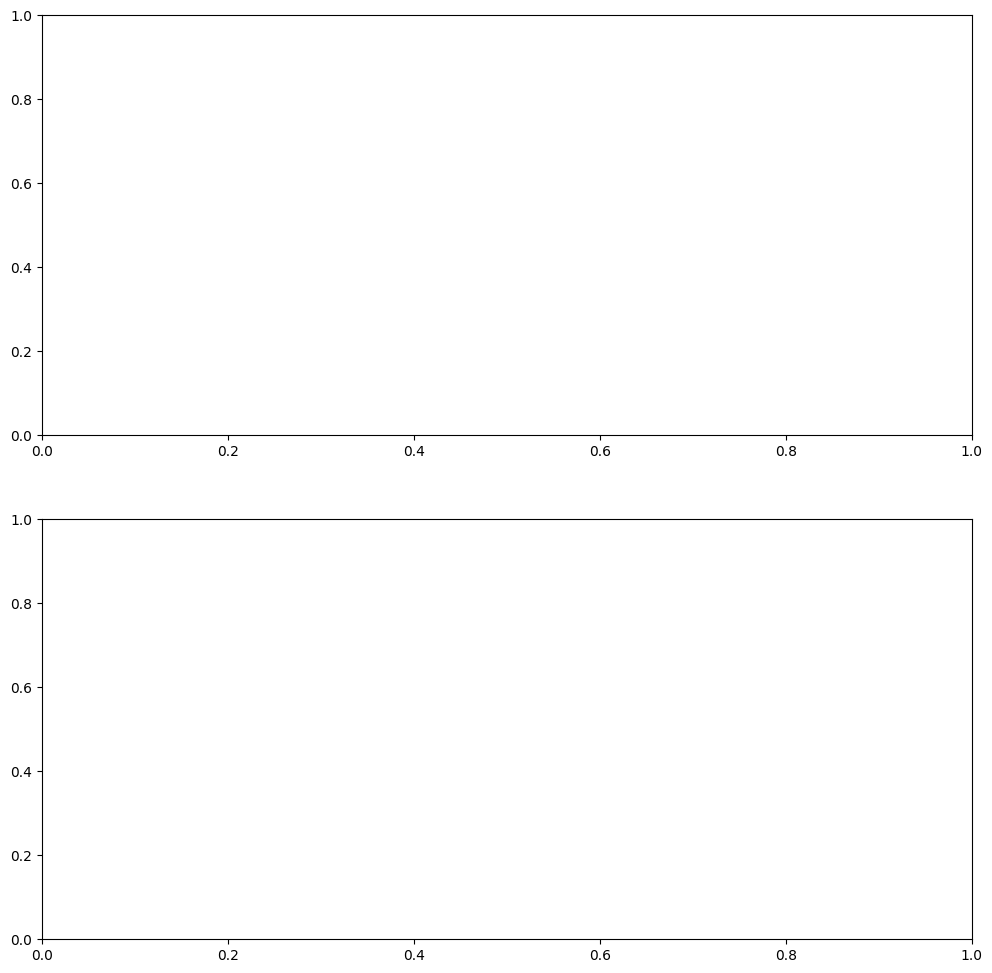

In [18]:
min_p, max_p = min(pressures), max(pressures)
print(min_p)
print(max_p)
if max_p - min_p == 0:
    lwidths = [3] * (len(pressures) - 1)  # grosor fijo si todas las presiones son iguales
else:
    lwidths = [1 + 6 * (p - min_p) / (max_p - min_p) for p in pressures[:-1]]
pressures.append(0)
print(len(pressures))
print(len(x))

# Preparar segmentos de línea
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Crear el gráfico
lc = LineCollection(segments, linewidths=lwidths, color='black')
fig, a = plt.subplots(2, figsize=(12, 12))

padding=10
# Trazo con grosor en a[0]
a[0].add_collection(lc)
a[0].scatter(x, y, color="black", s=lwidths, edgecolor="none")  # puntos
a[0].set_xlim(min(x) - padding, max(x) + padding)
a[0].set_ylim(min(y) - padding, max(y) + padding)
a[0].set_aspect('equal')
a[0].set_title("Trazo con grosor + puntos")

# Solo scatter en a[1]
a[1].scatter(x, y, color="black", s=lwidths, edgecolor="none")
a[1].set_xlim(min(x) - padding, max(x) + padding)
a[1].set_ylim(min(y) - padding, max(y) + padding)
a[1].set_aspect('equal')
a[1].set_title("Solo puntos")

plt.tight_layout()
plt.savefig("resultado.png")
plt.show()

In [ ]:
a.axis('off')
plt.tight_layout(pad=0)
canvas = FigureCanvas(fig)
canvas.draw()
s, (width, height) = canvas.print_to_buffer()

X = np.frombuffer(s, np.uint8).reshape((height, width, 4))

gray = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

# En lugar de cv2.imshow(), usa matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(closed, cmap='gray')
plt.axis('off')
plt.title("Gris")
plt.savefig("closed-res.png")
plt.show()

# Option 1: Save the figure to a file; can also be a file-like object (BytesIO,
# etc.).
#fig.savefig("test.png")
#
# Option 2: Save the figure to a string.
#canvas.draw()
#s, (width, height) = canvas.print_to_buffer()
#
# Option 2a: Convert to a NumPy array.
#X = np.frombuffer(s, np.uint8).reshape((height, width, 4))
#
# Option 2b: Pass off to PIL.
#from PIL import Image
#im = Image.frombytes("RGBA", (width, height), s)

In [ ]:
def catmull_rom_spline(P, n_points=100):
    """Interpolar una serie de puntos P usando Catmull-Rom spline."""
    def CR(p0, p1, p2, p3, t):
        return 0.5 * (
            2*p1 +
            (-p0 + p2)*t +
            (2*p0 - 5*p1 + 4*p2 - p3)*t**2 +
            (-p0 + 3*p1 - 3*p2 + p3)*t**3
        )

    curve = []
    for i in range(1, len(P)-2):
        for t in np.linspace(0, 1, n_points):
            point = CR(P[i-1], P[i], P[i+1], P[i+2], t)
            curve.append(point)
    return np.array(curve)

In [ ]:
P = np.array(list(zip(x, y)), dtype=np.float32)
smooth_curve = splines.CatmullRom(list(zip(x,y)))
canvas2 = np.ones((max(x) + 10, max(y) + 10, 3), dtype=np.uint8) * 255
interp_pressures = np.interp(np.linspace(0, len(pressures)-1, len(smooth_curve)),
                             np.arange(len(pressures)), pressures)
lw = 1 + 6 * (interp_pressures - min_p) / (max_p - min_p)



In [ ]:
# %%script false --no-raise-error
# Para la configuración 1. Se usan todos los sujetos PaHaW en base a su estado PD.
h_id_list = []
pd_id_list = []

subjects_id_list = list(subjects_tasks.keys())

for subject_id in subjects_id_list:
    if subjects_pd_status_years[subject_id][0] == 0:
        h_id_list.append(subject_id)
    else:
        pd_id_list.append(subject_id)

random.Random(17).shuffle(h_id_list)
random.Random(17).shuffle(pd_id_list)

# Hay 75 sujetos en total, 62 para entrenamiento y 13 para test.
test_id_list = h_id_list[:7]
train_id_list = h_id_list[7:]
test_id_list.extend(pd_id_list[:6])
train_id_list.extend(pd_id_list[6:])

In [ ]:
subjects_id_list = train_id_list + test_id_list
for letters_set in subjects_tasks[1][2].letters_sets_list:
    letters_set.generate_clippings(111, 1)

# Las imágenes de los recortes generados se copian a los directorios
# de entrenamiento y test en base al grupo al que pertenece el sujeto.
shutil.rmtree(os.path.join("generated", "test"), ignore_errors=True)
os.makedirs(os.path.join("generated", "test"))

test_clippings = {}
test_clippings_pd = {}

for letters_set in subjects_tasks[1][2].letters_sets_list:
    print(1)
    for clipping in letters_set.clippings_list:
        test_clippings[clipping.name] = clipping
        test_clippings_pd[clipping.name] = subjects_pd_status_years[subject_id][0]
        clipping.copy_clipping("test")

In [ ]:
mystroke = pahaw_loader.Stroke((0,0))

In [ ]:
mystroke